<a href="https://colab.research.google.com/github/wafa-b/Introduction-to-Deep-Learning-with-PyTorch/blob/master/Study%20jam%20challenge/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "wafaab" 
os.environ['KAGGLE_KEY'] = "c3b1752b44ed6f5e678f83cad98a13b2"

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip intel-image-classification

Archive:  intel-image-classification.zip
replace seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import OrderedDict

from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
batch_size = 64
valid_size = 0.2

#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize((150, 150)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((150, 150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data =  datasets.ImageFolder('seg_train/seg_train', transform=train_transforms)
test_data =  datasets.ImageFolder('seg_test/seg_test', transform=test_transforms)

#obtain trainig indicies that will be used as validation
num_train = len(train_data)
indicies = list(range(num_train))
np.random.shuffle(indicies)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indicies[split:], indicies[:split]
#Define samplers for obtaining the training and validation data
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

In [0]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

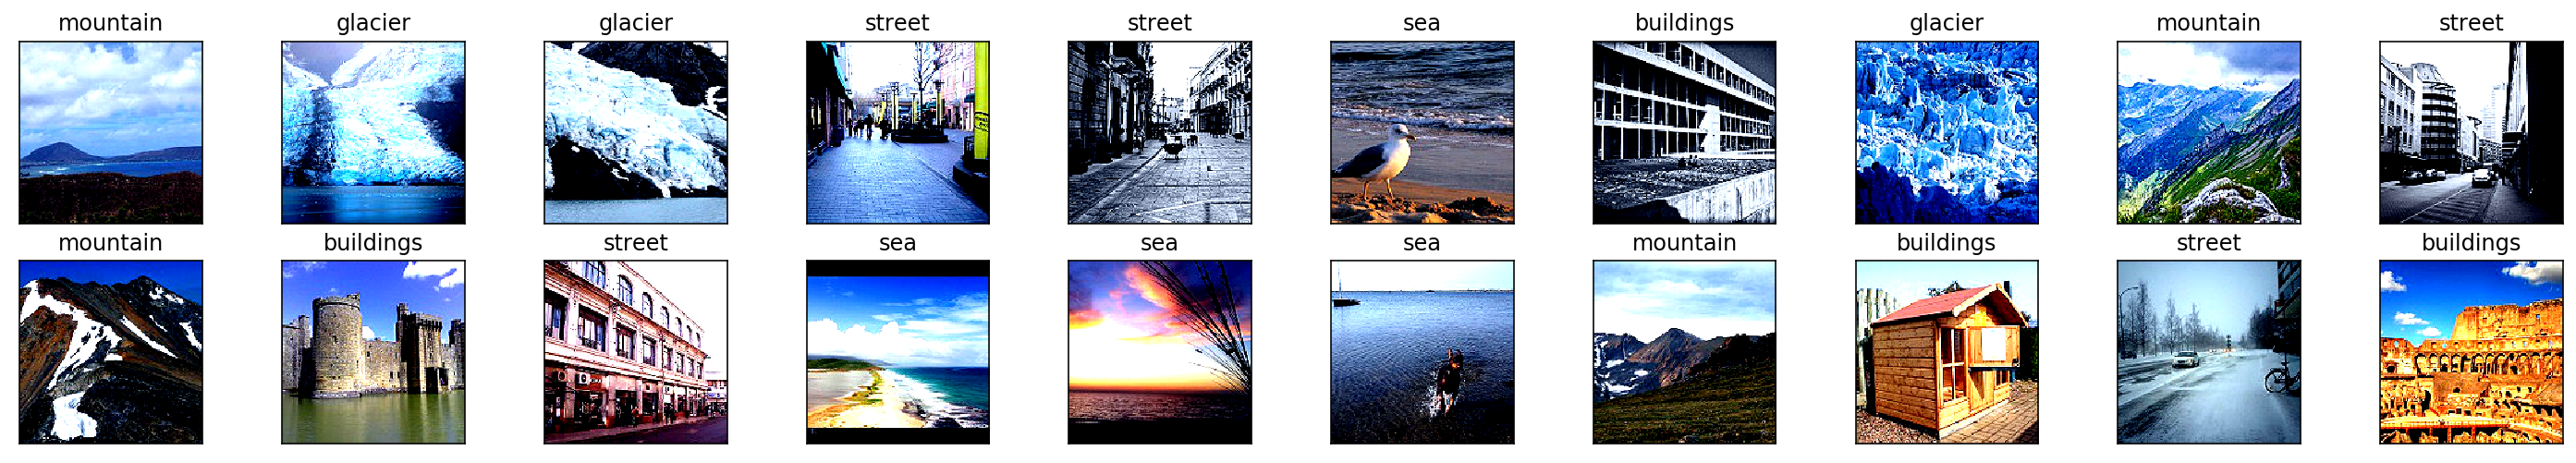

In [11]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [45]:
model = models.vgg19(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [49]:
# Use GPU if it's available
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.vgg19(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad=True 

model.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(4096, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(500, 6)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model.to(device);
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [0]:
# Loss function chosen based on log soft max layer in the model
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model.to(device);

In [51]:
# number of epochs to train the model
import numpy as np
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in train_loader:
        # move tensors to GPU if CUDA is available
        if device:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss (comapre the values of the output model to the actual labels)
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for images, labels in valid_loader:
        # move tensors to GPU if CUDA is available
        if device:
            images, labels = images.cuda(), labels.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'intel_image_classifier.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.314125 	Validation Loss: 0.284878
Validation loss decreased (inf --> 0.284878).  Saving model ...
Epoch: 2 	Training Loss: 0.290376 	Validation Loss: 0.200123
Validation loss decreased (0.284878 --> 0.200123).  Saving model ...
Epoch: 3 	Training Loss: 0.223003 	Validation Loss: 0.158834
Validation loss decreased (0.200123 --> 0.158834).  Saving model ...
Epoch: 4 	Training Loss: 0.182333 	Validation Loss: 0.130391
Validation loss decreased (0.158834 --> 0.130391).  Saving model ...
Epoch: 5 	Training Loss: 0.151695 	Validation Loss: 0.108741
Validation loss decreased (0.130391 --> 0.108741).  Saving model ...
Epoch: 6 	Training Loss: 0.120936 	Validation Loss: 0.090763
Validation loss decreased (0.108741 --> 0.090763).  Saving model ...
Epoch: 7 	Training Loss: 0.101880 	Validation Loss: 0.067636
Validation loss decreased (0.090763 --> 0.067636).  Saving model ...
Epoch: 8 	Training Loss: 0.081796 	Validation Loss: 0.065582
Validation loss decreased (0.06763

In [52]:
model.load_state_dict(torch.load('intel_image_classifier.pt'))

<All keys matched successfully>

In [53]:
#Define lists to monitor test loss and accuracy
test_loss=0.0
class_correct=list(0. for i in range(6))
class_total=list(0. for i in range(6))
#Define model for evaluation
model.eval()
for data,target in test_loader:
    #move tensors to GPU if CUDA is available
    if device:
        data,target=data.cuda(),target.cuda()
    #1.Forward pass:testloadercompute predicted outputs by passing inputs to the model
    output=model(data)
    #2.Calculate the loss
    loss=criterion(output,target)
    #3.Update test loss 
    test_loss+=loss.item()*data.size(0)
    #4.Convert output probabilities to predicted class
    _, pred=torch.max(output,1)
    #5.Compare predictions to true label
    correct=np.squeeze(pred.eq(target.data.view_as(pred)))
    #6.Calculate test accuracy for each object class
    for i in range(len(target)):
        label=target.data[i]
        class_correct[label]+=correct[i].item()
        class_total[label]+=1
# calculate and print avg test loss
test_loss=test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(6):
    if class_total[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%(
            classes[i],100*class_correct[i]/class_total[i],
            np.sum(class_correct[i]),np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)'%(classes[i]))
        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)'%(
    100.*np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct),np.sum(class_total)))

Test Loss: 0.431809

Test Accuracy of buildings: 91% (400/437)
Test Accuracy of forest: 99% (471/474)
Test Accuracy of glacier: 88% (492/553)
Test Accuracy of mountain: 88% (465/525)
Test Accuracy of   sea: 97% (498/510)
Test Accuracy of street: 94% (471/501)

Test Accuracy (Overall): 93% (2797/3000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

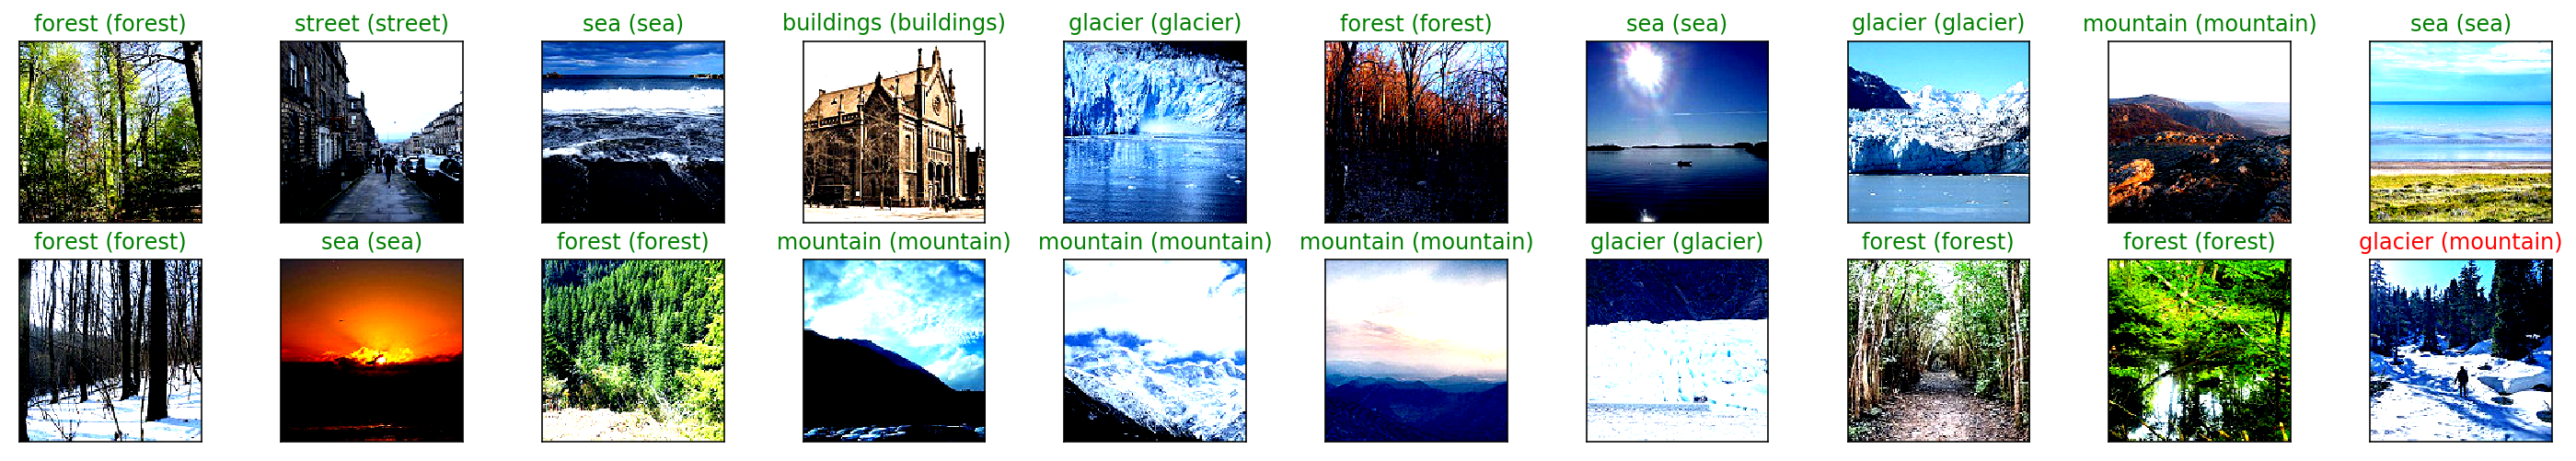

In [54]:
#To see one batch of test images
dataiter=iter(test_loader)
images,labels=dataiter.next()
images.numpy()
#move model inputs to cuda, if GPU available
if device:
    images=images.cuda()
#get sample outputs
output=model(images)
# convert output probabilities to predicted class
_, preds_tensor=torch.max(output,1)
preds=np.squeeze(preds_tensor.numpy()) if not device else np.squeeze(preds_tensor.cpu().numpy())

#plot the images in the batch, along with predicted and true labels
fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]],classes[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))